In [1]:
%matplotlib inline
from edward.util import Progbar
import tensorflow as tf
from utils import (generator_xy, visulize, accuracy, 
                  NN_classifier)
import keras
import edward as ed
import numpy as np
from observations import mnist
import matplotlib.pyplot as plt
from edward.models import Normal, Bernoulli, Categorical
import pickle
import seaborn as sns
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
sess = tf.InteractiveSession()
ed.set_seed(100)
M = 12000
num_latent = 32
num_hidden = 16
D = 28*28
num_class = 10
(x_train, y_train), (x_test, y_test) = mnist('./data')
y_train = tf.cast(y_train, tf.int32).eval()
y_test = tf.cast(y_test, tf.int32).eval()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_generator = generator_xy([x_train,y_train], M)

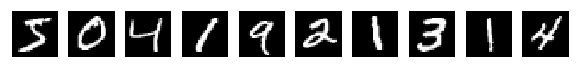

In [3]:
visulize(10, x_train)

In [4]:

def auto_encoder(x, W_encode, W_decode, b_endoce, b_decode):
    h = tf.nn.relu(tf.matmul(x,W_encode) + b_encode)
    h = tf.nn.sigmoid(tf.matmul(h,W_decode) + b_decode)
    return h


def encoder(x, W_encode, b_encode):
    h = tf.matmul(x,W_encode) + b_encode
    return h


In [5]:
M = 12000
num_latent = 32
num_hidden = 16
D = 28*28
num_class = 10

W_encode = Normal(loc = tf.zeros([D, num_latent]), scale = 0.01 * tf.ones([D, num_latent]))
W_decode = Normal(loc = tf.zeros([num_latent, D]), scale = 0.01 * tf.ones([num_latent,D]))
b_encode = Normal(loc = tf.zeros(num_latent), scale = 0.01 * tf.ones(num_latent))
b_decode = Normal(loc = tf.zeros(D), scale = 0.01 * tf.ones(D))
W_clf_1  = Normal(loc = tf.zeros([num_latent, num_hidden]), scale = tf.ones([num_latent, num_hidden]))
b_clf_1  = Normal(loc = tf.zeros(num_hidden), scale = tf.ones(num_hidden)) 
W_clf_2  = Normal(loc = tf.zeros([num_hidden,num_class]), scale = tf.ones([num_hidden, num_class]))
b_clf_2  = Normal(loc = tf.zeros(num_class), scale = tf.ones(num_class))


x = tf.placeholder(tf.float32, [None, D])

x_reconstruct = Normal(loc=auto_encoder(x, W_encode, W_decode, b_encode, b_decode),
                      scale = 0.1 *tf.ones([D]))
y = Categorical(logits = NN_classifier(encoder(x, W_encode, b_encode) 
                             , W_clf_1, W_clf_2, b_clf_1, b_clf_2))

In [6]:
qW_encode = Normal(loc = tf.Variable(tf.random_normal([D,num_latent])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([D,num_latent]))))
qW_decode = Normal(loc = tf.Variable(tf.random_normal([num_latent ,D])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_latent,D]))))
qb_encode = Normal(loc = tf.Variable(tf.random_normal([num_latent])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_latent]))))
qb_decode = Normal(loc = tf.Variable(tf.random_normal([D])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([D]))))

qW_clf_1 = Normal(loc = tf.Variable(tf.random_normal([num_latent,num_hidden])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_latent,num_hidden]))))
qW_clf_2 = Normal(loc = tf.Variable(tf.random_normal([num_hidden,num_class])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_hidden,num_class]))))
qb_clf_1 = Normal(loc = tf.Variable(tf.random_normal([num_hidden])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_hidden]))))
qb_clf_2 = Normal(loc = tf.Variable(tf.random_normal([num_class])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_class]))))



In [17]:
reconstruct = tf.stack([auto_encoder(x,qW_encode.sample(), 
                                   qW_decode.sample(), qb_encode.sample(), 
                                   qb_decode.sample()) 
                          for _ in range(4)])
tf.global_variables_initializer().run()
out = sess.run(reconstruct, feed_dict = {x: x_test})


(4, 10000, 784)


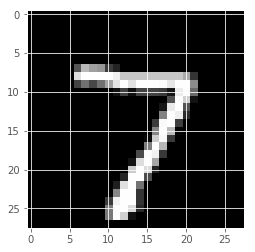

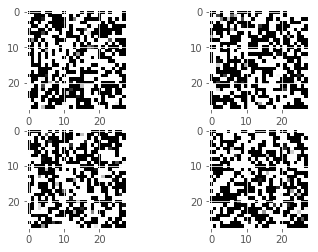

In [18]:
print(out.shape)
plt.imshow(x_test[0,:].reshape(28, 28), cmap = 'gray')
plt.show()
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(out[i,0,:].reshape(28,28),cmap = 'gray')
plt.show()

In [9]:
inference = ed.KLqp({W_encode:qW_encode, b_encode:qb_encode,
                    W_decode:qW_decode, b_decode:qb_decode, 
                    W_clf_1: qW_clf_1, W_clf_2: qW_clf_2, 
                    b_clf_1: qb_clf_1, b_clf_2: qb_clf_2}, 
                    data = {x: x_train, x_reconstruct: x_train, 
                           y: y_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()


In [10]:
n_epoch = 50
n_iter_per_epoch = x_train.shape[0] // M
loss = []
for epoch in range(1, n_epoch + 1):
    print("Epoch: {0}".format(epoch))
    avg_loss = 0.0

    pbar = Progbar(n_iter_per_epoch, verbose = 0)
    for t in range(1, n_iter_per_epoch + 1):
        pbar.update(t)
        x_batch, y_batch = next(x_train_generator)
        info_dict = inference.update(feed_dict={x: x_batch, x_reconstruct: x_batch, 
                                           y: y_batch})
        avg_loss += info_dict['loss']
        avg_loss = avg_loss / n_iter_per_epoch
        avg_loss = avg_loss / M
        loss.append(avg_loss)
    print("-log p(x) <= {:0.3f}".format(avg_loss))
    

Epoch: 1
-log p(x) <= 13034.309
Epoch: 2
-log p(x) <= 8459.882
Epoch: 3
-log p(x) <= 7401.033
Epoch: 4
-log p(x) <= 6626.003
Epoch: 5
-log p(x) <= 6016.225
Epoch: 6
-log p(x) <= 5472.677
Epoch: 7
-log p(x) <= 5031.723
Epoch: 8
-log p(x) <= 4693.309
Epoch: 9
-log p(x) <= 4445.958
Epoch: 10
-log p(x) <= 4223.319
Epoch: 11
-log p(x) <= 4051.656
Epoch: 12
-log p(x) <= 3896.586
Epoch: 13
-log p(x) <= 3739.721
Epoch: 14
-log p(x) <= 3639.449
Epoch: 15
-log p(x) <= 3451.699
Epoch: 16
-log p(x) <= 3240.828
Epoch: 17
-log p(x) <= 2964.371
Epoch: 18
-log p(x) <= 2566.869
Epoch: 19
-log p(x) <= 2521.611
Epoch: 20
-log p(x) <= 2114.890
Epoch: 21
-log p(x) <= 1880.551
Epoch: 22
-log p(x) <= 1703.701
Epoch: 23
-log p(x) <= 1562.272
Epoch: 24
-log p(x) <= 1319.558
Epoch: 25
-log p(x) <= 1225.594
Epoch: 26
-log p(x) <= 1057.202
Epoch: 27
-log p(x) <= 966.413
Epoch: 28
-log p(x) <= 861.934
Epoch: 29
-log p(x) <= 739.494
Epoch: 30
-log p(x) <= 820.776
Epoch: 31
-log p(x) <= 708.179
Epoch: 32
-log p(x) <

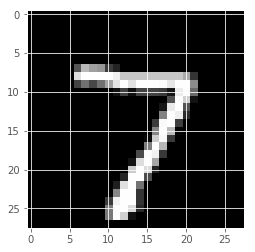

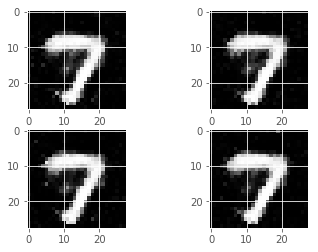

In [15]:
out = sess.run(reconstruct, feed_dict={x: x_test})
plt.imshow(x_test[0,:].reshape(28, 28), cmap = 'gray')
plt.show()
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(out[i,0,:].reshape(28,28),cmap = 'gray')
plt.show()

In [12]:
encode_weights = qW_encode.sample()
encode_bias = qb_encode.sample()
train_encoded = tf.matmul(x_train, encode_weights) + encode_bias
test_encoded = tf.matmul(x_test, encode_weights) + encode_bias
# with open('./data/encoded_train_BAE.pkl','wb') as f:
#     pickle.dump(train_encoded.eval(),f)
# with open('./data/encoded_test_BAE.pkl','wb') as f:
#     pickle.dump(test_encoded.eval(),f)

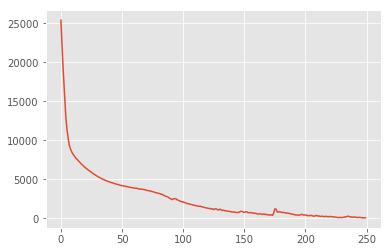

In [13]:
plt.plot(range(5 * 50), loss)
plt.show()